# Filtering data based on QC parameters

Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


... reading from cache file cache/Users-brendamelano-Desktop-Reprogramming_Osteosarcoma-Perturb_seq_analysis-OS384-OS384_pert.h5ad


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


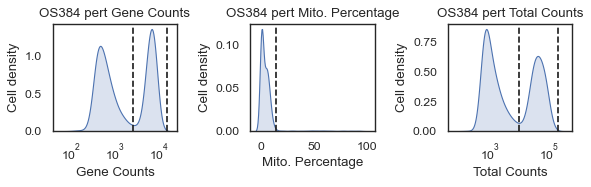

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:650: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["gene_count_corr"] = np.round(


Normalized count data: X, spliced, unspliced.
Extracted 5000 highly variable genes.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    297 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    336 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
regressing out ['n_counts', 'pct_counts_mt', 'ccdifference']
    sparse input is densified and may lead to high memory use


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


    finished (0:00:09)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


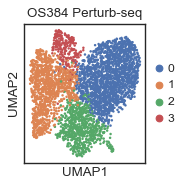

In [4]:
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import statsmodels.api as sm
import anndata as AnnData
import scrublet as scr
import cellrank as cr
import seaborn as sns
import scvelo as scv
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib
import networkx
import fsspec
import igraph
import scvi
import desc 
import umap
import h5py
import os


# Setting the figure parameters
sc.set_figure_params(figsize=(2.5, 2.5))
sc.settings.verbosity = 3 
plt.rcParams.update({'font.size': 12})  # Adjusts the general font size
%load_ext rpy2.ipython
%matplotlib inline     
np.random.seed(42)


# Reading in H5 file
#adata = sc.read_10x_h5('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/filtered_feature_bc_matrix.h5')


# Reading in H5 file. Contains the cutoff at 9k cells
#adata = sc.read_10x_h5('/Users/brendamelano/Desktop/temp_OS384_temp_files/filtered_feature_bc_matrix.h5')


# Reading in loom file. Needed for RNA velocity
adata = scv.read('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/OS384_pert.loom', cache = True)


# Making the var names unique
adata.var_names_make_unique()


# Filtering as is done in Seurat
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


# Computing mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


# Creating df for thresholds for different variables
variables = [
    ('n_genes_by_counts', [(2500, '--'), (15000, '--')]),
    ('pct_counts_mt', [(14, '--')]),
    ('total_counts', [(10000, '--'), (200000, '--')])
]


# Dictionary for new titles
titles = {
    'n_genes_by_counts': 'Gene Counts',
    'pct_counts_mt': 'Mito. Percentage',
    'total_counts': 'Total Counts'
}


# Setting the theme without gridlines
sns.set_theme(style="white")


# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5))


# Iterate over the variables and their respective lines to plot
for ax, (var, lines) in zip(axes, variables):
    sns.kdeplot(data=adata.obs, x=var, fill=True, alpha=0.2, ax=ax,
                log_scale=True if var != 'pct_counts_mt' else False)
    for line, style in lines:
        ax.axvline(x=line, color='k', linestyle=style)
    ax.set_title(f"OS384 pert {titles[var]}")  # Simpler title without extra text
    ax.set_xlabel(titles[var])  # Optionally keep the x-label as the new title
    ax.set_ylabel("Cell density")


# Adjust layout to prevent overlap
plt.tight_layout()


# Save the figure as SVG
#plt.savefig("/Users/brendamelano/Desktop/OS384_pert_filtering.svg")


# Show the plot
plt.show()


# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] >= 10000) &
                        (adata.obs['total_counts'] <= 200000) &
                        (adata.obs['n_genes_by_counts'] >= 2500) &
                        (adata.obs['n_genes_by_counts'] < 15000) & #pct_counts_mt
                        (adata.obs['pct_counts_mt'] < 14)
                        ]


#scv.pp.filter_genes(adata, min_shared_counts=20)


# Normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)


# filtering the dataset to only keep the most variable genes
# this is redundant to selecting highly variable genes
scv.pp.filter_genes_dispersion(adata, n_top_genes=5000)
# previously at 3000
# 5000 for testing KD


# Make sure that the log transformation is where it belongs in this preprocessing sequence
scv.pp.log1p(adata)

# making the adata copy below might have to go before the log transformation


# preserving the counts
adata.layers["counts"] = adata.X.copy() 


# freezing the data in raw
adata.raw = adata


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, 
    subset=True,
    layer="counts"
)


# 3000 for normal analysis
# 5000 for tesing KD

genes = adata.var.index.values



# reading in cell cycle genes in case I want to regress on that
cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]


# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]


# Computing cell cycle scores
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)


# Computing ccdifference
adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']


# Linear dimensionality reduction
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#adata.raw = adata
adata = adata[:, adata.var.highly_variable]


# Regressing out the total number of counts, mitochondrial percentage and ccdifference scores
sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])


# Remove scaling for testing KD
sc.pp.scale(adata, max_value=10)


# Performing dimensionality reduction with PCA
sc.tl.pca(adata, svd_solver='arpack')


# Identifying neighbors for umap
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=10)
sc.tl.umap(adata)


# Leiden clustering
sc.tl.leiden(adata, resolution = 0.25)


# Create a figure and a set of subplots
fig, ax = plt.subplots()


# Plot the UMAP
sc.pl.umap(
    adata,
    color=["leiden"],
    title="OS384 Perturb-seq",
    size=20,
    show=False,  # Prevents the immediate display of the plot
    ax=ax  # Directs the plot to the axes object created earlier
)


# Use tight_layout to adjust the spacing
plt.tight_layout()


# Save the plot as an SVG file
#plt.savefig("/Users/brendamelano/Desktop/OS384_perturbseq_umap_plot.svg", format='svg')


# After saving, you can also display the plot if you wish
plt.show()

# Module score enrichment

computing score 'angiogenic_score'
    finished: added
    'angiogenic_score', score of gene set (adata.obs).
    98 total control genes are used. (0:00:00)


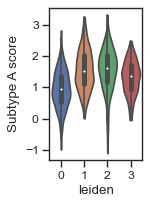

computing score 'Subtype_B_score'
    finished: added
    'Subtype_B_score', score of gene set (adata.obs).
    190 total control genes are used. (0:00:00)


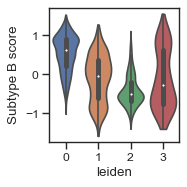

computing score 'Subtype_C_score'
    finished: added
    'Subtype_C_score', score of gene set (adata.obs).
    99 total control genes are used. (0:00:00)


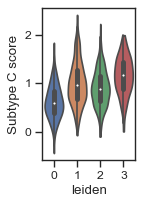

In [3]:
# Reading in gene lists for gsea
Subtype_A_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_A_module.csv')]


# Keeping only genes that appear in the adata
Subtype_A_genes = [x for x in Subtype_A_genes if x in adata.var_names]


# Computing gsea
sc.tl.score_genes(adata, Subtype_A_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='angiogenic_score', random_state=0, copy=False, use_raw=None)


sc.pl.violin(adata, ['angiogenic_score'], groupby='leiden', 
             stripplot=False, inner='box', 
             ylabel = 'Subtype A score')



# reading in gene lists for gsea
subtype_B_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv')]




# keeping only genes that appear in the adata
subtype_B_genes = [x for x in subtype_B_genes if x in adata.var_names]


# Computing gsea
sc.tl.score_genes(adata, subtype_B_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_B_score', random_state=0, copy=False, use_raw=None)

# Setup figure and axis manually
fig, ax = plt.subplots()


# Generate the violin plot directly on the provided axis, with 'show=False' to integrate it properly without displaying immediately
sc.pl.violin(adata, ['Subtype_B_score'], groupby='leiden', stripplot=False, inner='box', ylabel='Subtype B score', ax=ax, show=False)


# Apply tight layout to optimize spacing
plt.tight_layout()


# Save the figure to SVG
fig.savefig("/Users/brendamelano/Desktop/SubtypeB_violin_plot.svg", format='svg')

# Display the plot, if desired
plt.show()

# reading in gene lists for gsea
subtype_C_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_C_module.csv')]


adata.var_names_make_unique()


# keeping only genes that appear in the adata
subtype_C_genes = [x for x in subtype_C_genes if x in adata.var_names]


# Computing gsea
sc.tl.score_genes(adata, subtype_C_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_C_score', random_state=0, copy=False, use_raw=None)

sc.pl.violin(adata, ['Subtype_C_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel = 'Subtype C score')



# Subtype labeling

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


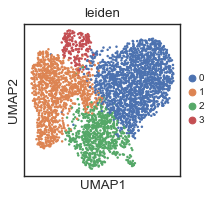

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


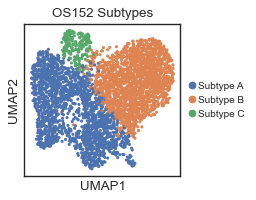

In [4]:
sc.pl.umap(adata, color=['leiden'], legend_fontsize=9, size = 20)

adata.obs['leiden'] = adata.obs['leiden'].astype('category')

adata.obs['leiden'][adata.obs['leiden']=='1']='2'


# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'Subtype A': ['2'],  'Subtype B': ['0'], 'Subtype C':['3']}


# Initialize empty column in cell metadata
adata.obs['Subtype'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'Subtype'] = i

    
# creating a dataframe with the cluster IDs
subtypes = pd.DataFrame(adata.obs['Subtype'].values)


# Define the number of clusters
n_subtypes = len(subtypes[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_subtypes)

# Create a dictionary that maps each cluster ID to a color from the palette
#subtype_colors = dict(zip(sorted(subtypes[0].unique()), colors))

# Map the cluster IDs to their corresponding colors
#adata.uns['subtype_colors'] = [subtype_colors[c] for c in subtypes[0]]

sc.pl.umap(adata, color=['Subtype'], legend_fontsize=9, title = "OS152 Subtypes") #, palette = subtype_colors

# saving the adata file with the cluster ids
#adata.write("/Users/brendamelano/Desktop/OS152_adata_labeled.h5ad")

#adata = sc.read("/Users/brendamelano/Desktop/OS152_adata_labeled.h5ad")

In [5]:
# For loom files
adata.obs.index = adata.obs.index.str.replace('OS384_pert:', '').str.replace('x', '') + '-1'


### Reading in mol info data from wynton
# Reading in the macthed cell barcodes and guides that were generated in wynton
molecular_data = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/OS384_molecular_data.csv', index_col=0) 


# Keep only the 'feature_ids' and 'cell_barcodes' columns
molecular_data = molecular_data[['feature_ids', 'cell_barcodes']]


molecular_data['feature_ids'] = molecular_data['feature_ids'].str.strip("b''")
molecular_data['feature_ids'] = molecular_data['feature_ids'].str.replace(r'(-1i|-2i)$', '', regex=True)

# removing the b'' string from cell barcodes
molecular_data['cell_barcodes'] = molecular_data['cell_barcodes'].str.strip("b''")


# Remove duplicate rows across the entire DataFrame
molecular_data_unique = molecular_data.drop_duplicates()

molecular_data_unique['cell_barcodes'] = molecular_data_unique['cell_barcodes'].apply(lambda x: f"{x}-1")


molecular_data_unique = molecular_data_unique.set_index('cell_barcodes')

adata.obs = adata.obs.assign(cell_barcode=adata.obs.index)

adata.obs['Gene'] = "NT-ctrl"

for barcode in molecular_data_unique.index:
    if barcode in adata.obs.index:
        # If barcode exists in AnnData, add/update gene info in .obs
        # Example: Add a concatenated string of genes to a new column, handling duplicates
        genes = molecular_data_unique.loc[barcode, 'feature_ids']
        gene_str = ', '.join(genes) if isinstance(genes, pd.Series) else genes
        adata.obs.at[barcode, 'Gene'] = gene_str
    else:
        # If barcode does not exist, add a new entry (optional, depends on your analysis needs)
        # You might need to handle adding new cells to `.X` or other attributes depending on your data structure
        genes = 'NT-ctrl'
        
# Filter observations where 'Gene' column does not contain a comma
adata = adata[~adata.obs['Gene'].str.contains(',')].copy()


# Convert 'feature_ids' column to string
#adata['feature_ids'] = adata['feature_ids'].astype(str)

# Filter rows where 'feature_ids' column contains the string "LT"
#filtered_data = merged_data[merged_data['feature_ids'].str.contains("LT", na=False)]


# Define a function that replaces any string containing 'control' with 'control'
def replace_with_control(gene_string):
    if 'NT-ctrl' in gene_string:
        return 'NT-ctrl'
    else:
        return gene_string

    
# Apply the function to the 'Gene' column
adata.obs['Gene'] = adata.obs['Gene'].apply(replace_with_control)

kd_counts = adata.obs['Gene'].value_counts()

# Printing the counts
print(kd_counts)


NT-ctrl    54
NFE2L3     39
TCF4       38
IRF1       37
STAT1      26
NR0B1      18
JUN        14
NFKB2      14
TSHZ2      12
Name: Gene, dtype: int64


# Checking that the kd worked

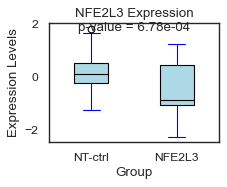

In [7]:
from scipy.stats import mannwhitneyu

# Assuming 'adata' is an AnnData object with the necessary data
gene = 'NFE2L3'

adata_ctrl = adata[adata.obs['Gene'] == 'NT-ctrl']
adata_gene = adata[adata.obs['Gene'] == gene]

ctrl_expression = adata_ctrl[:, gene].X.flatten()
gene_expression = adata_gene[:, gene].X.flatten()

# Prepare data for box plot
data_to_plot = [ctrl_expression, gene_expression]

# Conduct Mann-Whitney U test
u_stat, p_value = mannwhitneyu(ctrl_expression, gene_expression, alternative='two-sided')

# Plotting
plt.figure(figsize=(3, 2.5))
plt.boxplot(data_to_plot, widths=0.4, patch_artist=True, medianprops={'color': 'black'}, boxprops={'facecolor': 'lightblue'}, whiskerprops={'color': 'blue'}, capprops={'color': 'blue'})

# Customize plot with labels
plt.xticks([1, 2], ['NT-ctrl', gene])
plt.xlabel('Group')
plt.ylabel('Expression Levels')
plt.title('NFE2L3 Expression')

# Annotate plot with p-value
plt.text(1.5, max(np.concatenate(data_to_plot))-.2 , f'p-value = {p_value:.2e}', ha='center', va='bottom')

plt.tight_layout()

# Save the plot as an SVG file
plt.savefig('/Users/brendamelano/Desktop/expression_boxplot_NFE2L3.svg', format='svg')

# Display the plot
plt.show()

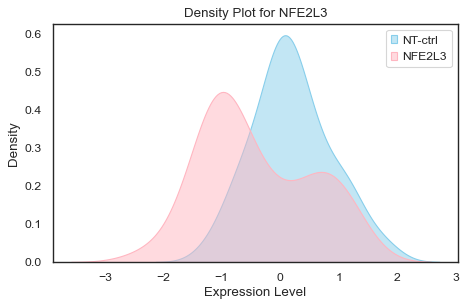

<Figure size 200x200 with 0 Axes>

In [7]:
# Assuming 'adata' is an AnnData object already loaded with the data
gene = 'NFE2L3'

adata_ctrl = adata[adata.obs['Gene'] == 'NT-ctrl']
adata_gene = adata[adata.obs['Gene'] == gene]

ctrl_expression = adata_ctrl[:, gene].X.flatten()
gene_expression = adata_gene[:, gene].X.flatten()

# Set up the figure
plt.figure(figsize=(6, 4))

# Create density plots
sns.kdeplot(ctrl_expression, color='skyblue', fill=True, alpha=0.5, label='NT-ctrl')
sns.kdeplot(gene_expression, color='lightpink', fill=True, alpha=0.5, label=gene)

plt.title(f'Density Plot for {gene}')
plt.xlabel('Expression Level')
plt.ylabel('Density')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# If saving the plot is desired, uncomment the next lines:
plt.savefig('/Users/brendamelano/Desktop/OS384_pert_NFE2L3_density_plot.svg', format='svg')

# Generating subtype and target df for modeling

In [60]:
# Extracting the required columns
df = adata.obs[['Gene', 'Subtype']]


# Creating one-hot encoding for the Gene column
one_hot = pd.get_dummies(df['Gene'])
df = df.join(one_hot)



# Adding a 'cell_line' column with all values as 'OS384'
df['cell_line'] = 'OS384'

df = df.drop(columns=['Gene'])



# Saving the DataFrame
df.to_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/OS384_Subtype_target_for_modeling.csv')


,Subtype,IRF1,JUN,NFE2L3,NFKB2,NR0B1,NT-ctrl,STAT1,TCF4,TSHZ2,cell_line
CellID,,,,,,,,,,,
AAACCCAAGCATTTCG-1,Subtype B,0,0,0,0,0,0,0,0,1,OS384
AAAGGTAAGTGGCAGT-1,Subtype B,0,0,1,0,0,0,0,0,0,OS384
AACCTTTAGACGAGCT-1,Subtype A,0,0,1,0,0,0,0,0,0,OS384
AACCTTTAGTGTTGTC-1,Subtype B,1,0,0,0,0,0,0,0,0,OS384
AACCTTTCAGATGCGA-1,Subtype B,1,0,0,0,0,0,0,0,0,OS384
...,...,...,...,...,...,...,...,...,...,...,...
TTGCGTCTCACGGTCG-1,Subtype B,0,0,1,0,0,0,0,0,0,OS384
TTCTTCCTCCACGGAC-1,Subtype A,0,0,0,0,0,0,0,1,0,OS384
TTGATGGTCTGTCAGA-1,Subtype A,1,0,0,0,0,0,0,0,0,OS384


Data contains NaNs or infinite values
Optimization terminated successfully.
         Current function value: 0.906605
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                Subtype   No. Observations:                 6647
Model:                        MNLogit   Df Residuals:                     6623
Method:                           MLE   Df Model:                           22
Date:                Fri, 24 May 2024   Pseudo R-squ.:                 0.04007
Time:                        15:27:10   Log-Likelihood:                -6026.2
converged:                       True   LL-Null:                       -6277.8
Covariance Type:            nonrobust   LLR p-value:                 1.640e-92
Subtype=Subtype B       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.4759      0.143     -3.332      

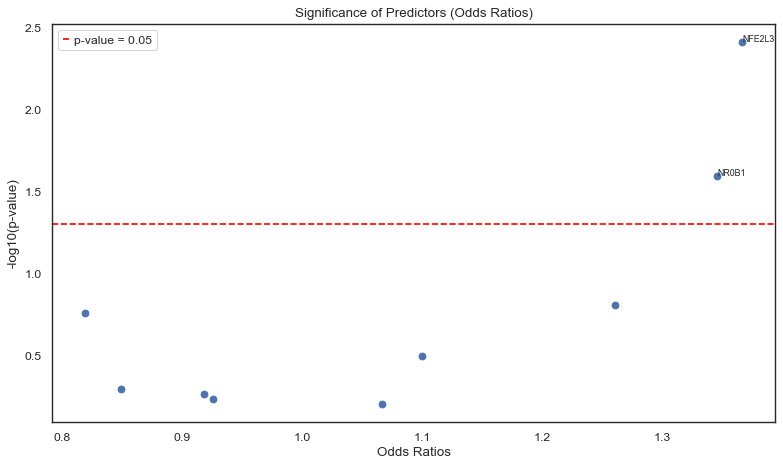

In [4]:

import statsmodels.api as sm
from sklearn.utils import shuffle

# Reading the DataFrame back in to ensure it was saved correctly
loaded_df = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS384/OS384_Subtype_target_for_modeling.csv', index_col='CellID')

# Reading the DataFrame back in to ensure it was saved correctly
OS742_df = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS742/OS742_Subtype_target_for_modeling.csv', index_col='CellID')

# Reading the DataFrame back in to ensure it was saved correctly
OS833_df = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS833/OS833_Subtype_target_for_modeling.csv', index_col='CellID')

# Combining DataFrames
combined_df = pd.concat([loaded_df, OS742_df, OS833_df])

# Shuffling the combined DataFrame
shuffled_df = shuffle(combined_df)
shuffled_df.head(70)

# Preparing data for multinomial logistic regression
X = shuffled_df.drop(columns=['Subtype', 'NT-ctrl'])  # Removing 'NT-ctrl' to use as reference, 'Subtype' is the target
y = shuffled_df['Subtype']
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding for categorical variables including 'cell_line'

if np.any(np.isnan(X)) or np.any(np.isinf(X)):
    print("Data contains NaNs or infinite values")
    # Filling NaN values with the mean of each column as an example
    X = X.fillna(0)

# Fitting the model
model = sm.MNLogit(y, sm.add_constant(X))
result = model.fit()

# Getting the summary of the model to check significant coefficients
model_summary = result.summary()
print(model_summary)

summary_df = result.summary2().tables[1]

# Removing 'cell_line' coefficients and the constant
filters = summary_df.index.str.contains("cell_line") | (summary_df.index == 'const')
summary_df = summary_df[~filters]

# Calculating -log10 of the p-values
summary_df['neg_log_pvalue'] = -np.log10(summary_df['P>|t|'])

# Calculating odds ratios
summary_df['odds_ratio'] = np.exp(summary_df['Coef.'])

# Threshold for significance
pvalue_threshold = -np.log10(0.05)


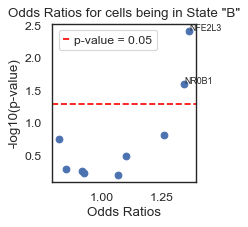

In [5]:

# Plotting Odds Ratios vs. -log(p-value)
plt.figure(figsize=(3, 3))
plt.scatter(summary_df['odds_ratio'], summary_df['neg_log_pvalue'], color='b')
plt.axhline(pvalue_threshold, color='red', linestyle='--', label='p-value = 0.05')
plt.xlabel('Odds Ratios')
plt.ylabel('-log10(p-value)')
plt.title('Odds Ratios for cells being in State "B"')

# Annotate only significant points
for i, txt in enumerate(summary_df.index):
    if summary_df['neg_log_pvalue'][i] > pvalue_threshold:
        plt.annotate(txt, (summary_df['odds_ratio'][i], summary_df['neg_log_pvalue'][i]), fontsize=8)

plt.legend()
plt.tight_layout()
plt.savefig("/Users/brendamelano/Desktop/perturb_seq_plot_odds_ratios.svg", format='svg')  # Save as SVG
plt.show()


# scVI dim reduction

# RNA velocity

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on distances
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1202 [00:00<?, ?gene/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:06:49) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/3803 [00:00<?, ?cells/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


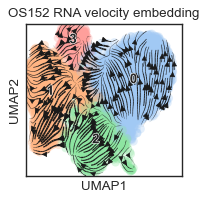

In [8]:
# computing the moments
scv.pp.moments(adata, mode = 'distances')
 

# recovering dynamics
scv.tl.recover_dynamics(adata)

# inferring the DYNAMIC velocities
scv.tl.velocity(adata, mode='dynamical')


# computing the velocity graph
scv.tl.velocity_graph(adata)

# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden'].astype('int64').values)

# Define the number of clusters
n_clusters = len(clusters[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)

# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))

# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]

# Set the plot style to 'white' to remove grid lines
sns.set_style('white')


# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', color='leiden', 
                                 palette=colors, title = 'OS152 RNA velocity embedding',
                                frameon = True)

# Chisquared analysis

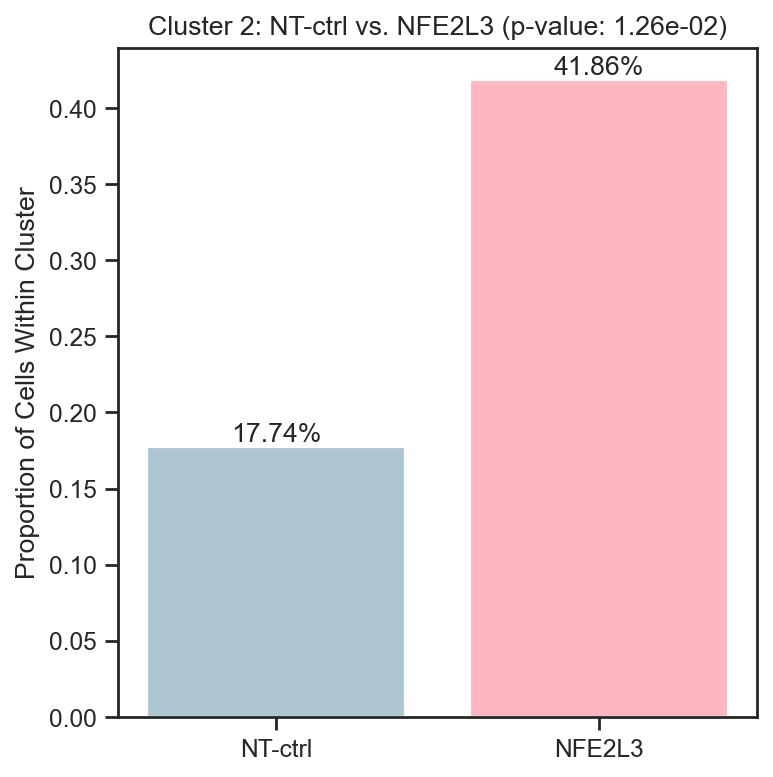

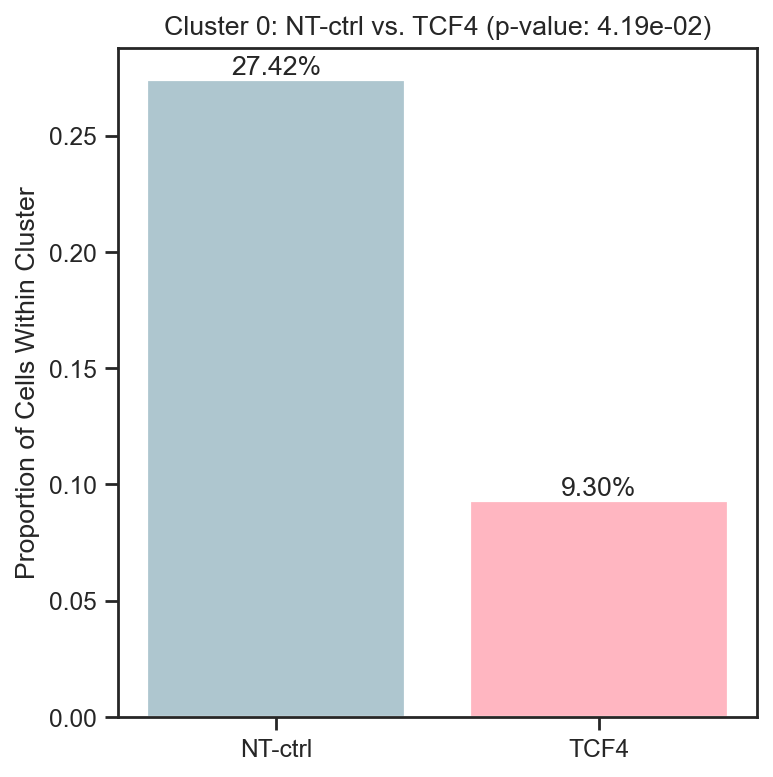

In [11]:
# Use the hdf5 file for this not the loom file
output_dir = "/Users/brendamelano/Desktop/"
os.makedirs(output_dir, exist_ok=True)

# Assuming adata is your AnnData object
significance_threshold = 0.05

# Unique genes excluding 'control'
unique_genes = adata.obs['Gene'].unique()
unique_genes = unique_genes[unique_genes != 'NT-ctrl']

# Iterate over each unique gene
for gene in unique_genes:
    # Iterate over each cluster
    for cluster in adata.obs['leiden'].unique():
        # Construct a contingency table
        contingency_table = pd.DataFrame(
            [
                [
                    ((adata.obs['Gene'] == gene) & (adata.obs['leiden'] == cluster)).sum(),
                    ((adata.obs['Gene'] == gene) & (adata.obs['leiden'] != cluster)).sum(),
                ],
                [
                    ((adata.obs['Gene'] == 'NT-ctrl') & (adata.obs['leiden'] == cluster)).sum(),
                    ((adata.obs['Gene'] == 'NT-ctrl') & (adata.obs['leiden'] != cluster)).sum(),
                ],
            ],
            index=[f"{gene}", "NT-ctrl"],
            columns=[f"In_Cluster_{cluster}", f"Outside_Cluster_{cluster}"]
        )

        # Adjust for zeros if necessary
        epsilon = 1e-10
        contingency_table += epsilon

        # Perform chi-squared test
        chi2, p, _, _ = chi2_contingency(contingency_table)
        is_significant = p < significance_threshold

        # Only plot if the result is significant
        if is_significant:
            # Cells for the gene of interest within and outside the cluster
            gene_in_cluster = ((adata.obs['Gene'] == gene) & (adata.obs['leiden'] == cluster)).sum()
            gene_total = (adata.obs['Gene'] == gene).sum()
            prop_gene_in_cluster = gene_in_cluster / gene_total

            # Cells for the control within and outside the cluster
            control_in_cluster = ((adata.obs['Gene'] == 'NT-ctrl') & (adata.obs['leiden'] == cluster)).sum()
            control_total = (adata.obs['Gene'] == 'NT-ctrl').sum()
            prop_control_in_cluster = control_in_cluster / control_total

            # Plotting
            categories = ['NT-ctrl', gene]
            proportions = [prop_control_in_cluster, prop_gene_in_cluster]
            plt.figure(figsize=(5, 5))
            bars = plt.bar(categories, proportions, color=['#aec6cf', '#ffb6c1'])

            plt.ylabel('Proportion of Cells Within Cluster')
            plt.title(f'Cluster {cluster}: NT-ctrl vs. {gene} (p-value: {p:.2e})')

            # Annotate bars with their respective percentages
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width() / 2., height, f'{height:.2%}', ha='center', va='bottom')

            # Use tight_layout() before saving
            plt.tight_layout()

            # Construct a unique filename for each plot
            filename = f"{gene}_vs_NT-ctrl_cluster_{cluster}.svg"
            filepath = os.path.join(output_dir, filename)

            # Save the plot as an SVG file
            plt.savefig(filepath, format='svg')

            # Optionally, display the plot
            plt.show()

            # Close the plot after saving and displaying to free memory and ensure the next plot is fresh
            plt.close()
            # Setup figure and axis manually

       

In [7]:
# Ensure the directory for saving SVG files exists
output_dir = "/Users/brendamelano/Desktop/"
os.makedirs(output_dir, exist_ok=True)

for gene in unique_genes:
    for cluster in adata.obs['leiden'].unique():
        # Your existing code for constructing the contingency table and performing the chi-squared test

        if is_significant:
            # Your existing plotting code

            plt.ylabel('Proportion of Cells Within Cluster')
            plt.title(f'Cluster {cluster}: NT-ctrl vs. {gene} (p-value: {p:.2e})')

            # Annotate bars with their respective percentages
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width() / 2., height, f'{height:.2%}', ha='center', va='bottom')

            # Use tight_layout() before saving
            plt.tight_layout()

            # Construct a unique filename for each plot
            filename = f"{gene}_vs_NT-ctrl_cluster_{cluster}.svg"
            filepath = os.path.join(output_dir, filename)

            # Save the plot as an SVG file
            plt.savefig(filepath, format='svg')

            # Optionally, display the plot
            plt.show()

            # Close the plot after saving and displaying to free memory and ensure the next plot is fresh
            plt.close()

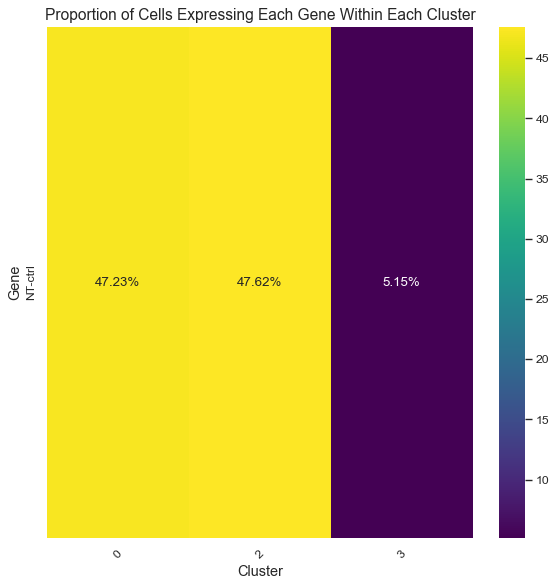

In [17]:
clusters_sorted = sorted(adata.obs['leiden'].unique())
gene_clusters = pd.DataFrame(columns=clusters_sorted)

# First, ensure 'NT-ctrl' is included at the beginning of the genes list
unique_genes = np.append('NT-ctrl', adata.obs['Gene'].unique())

# Fill the DataFrame
for gene in unique_genes:
    percentages = []
    gene_total = (adata.obs['Gene'] == gene).sum()  # Total cells expressing the gene across all clusters
    if gene_total == 0:  # Handle 'NT-ctrl' and any gene not found to avoid division by zero
        percentages = [0 for _ in clusters_sorted]
    else:
        for cluster in clusters_sorted:
            gene_in_cluster = ((adata.obs['Gene'] == gene) & (adata.obs['leiden'] == cluster)).sum()
            prop_gene_in_cluster = gene_in_cluster / gene_total  # Proportion of cells in this cluster for the gene
            percentages.append(prop_gene_in_cluster)
    gene_clusters.loc[gene] = percentages

# Convert to percentages
gene_clusters *= 100

# Convert each value to a string with a percentage sign for annotation
gene_clusters_str = gene_clusters.applymap(lambda x: "{:.2f}%".format(x))

# Plotting the heatmap
plt.figure(figsize=(7.5,7.5))
sns.heatmap(gene_clusters, annot=gene_clusters_str, fmt="s", cmap='viridis')
plt.title('Proportion of Cells Expressing Each Gene Within Each Cluster', fontsize=14)
plt.ylabel('Gene', fontsize=13)
plt.xlabel('Cluster', fontsize=13)
plt.xticks(rotation=45)
plt.tight_layout()

# Adjust the file path for saving the figure as needed
plt.savefig('/Users/brendamelano/Desktop/OS384_Percent_in_cluster_per_target.svg', format='svg')
plt.show()

# Visualizing cells from a certain target

In [16]:
adata.obs['NFE2L3'] = pd.Categorical(adata.obs['Gene'].apply(lambda x: 1 if x == 'TCF4' else 0))


adata = adata[adata.obs['NFE2L3'].sort_values(ascending=False).index]

# Define a custom color palette where 'False' is gray and 'True' is the default color (e.g., orange)
custom_palette = ['#808080', 'orange']  # gray for 'False', orange for 'True'

# Reorder data so that 'True' values are plotted last (on top)
adata_temp = adata[adata.obs['NFE2L3'].sort_values().index]


# Plot the UMAP with the custom color palette and increased dot size
sc.pl.umap(adata_temp, color='NFE2L3', palette=custom_palette, 
           add_outline=True, s=30, title='OS384 NFE2L3 perturbed cells')

# ,        save = "OS384_depleted_barcodes.svg"

# DGEA

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


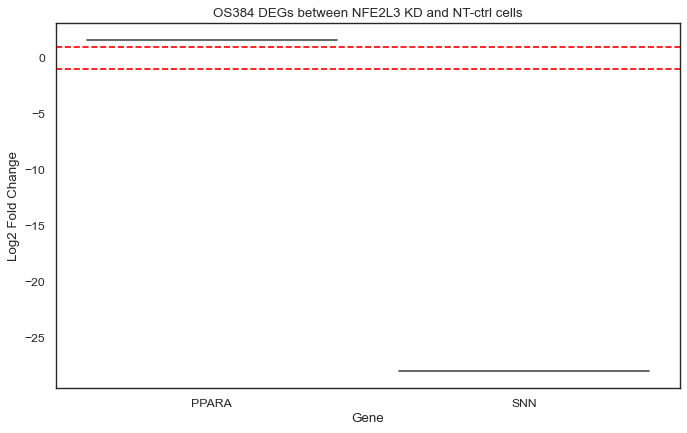

       Gene  Log2 fold change   P-value  Adjusted P-value
0     PPARA          1.614577  0.000012          0.034145
4999    SNN        -28.020033  0.000014          0.034145


In [9]:
def perform_dge_analysis(adata, gene_of_interest, control='NT-ctrl'):
    # Filter the data for the specified gene and control
    adata_filtered = adata[adata.obs['Gene'].isin([control, gene_of_interest])].copy()

    # Create a grouping variable
    adata_filtered.obs['group'] = adata_filtered.obs['Gene']

    # Perform differential gene expression analysis directly comparing 'control' vs the specified gene
    sc.tl.rank_genes_groups(adata_filtered, groupby='group', groups=[gene_of_interest], reference=control)

    # Access the differential expression results
    results = adata_filtered.uns['rank_genes_groups']

    # Extract the names, log fold changes, and p-values for the specified gene group
    gene_names = results['names'][gene_of_interest]
    logfoldchanges = results['logfoldchanges'][gene_of_interest]
    pvals = results['pvals'][gene_of_interest]
    pvals_adj = results['pvals_adj'][gene_of_interest]

    # Create a DataFrame
    df = pd.DataFrame({
        'Gene': gene_names,
        'Log2 fold change': logfoldchanges,
        'P-value': pvals,
        'Adjusted P-value': pvals_adj
    })

    # Filter the DataFrame for significant log fold changes and adjusted p-values
    significant_genes = df[(np.abs(df['Log2 fold change']) >= 1) & (df['Adjusted P-value'] < 0.05)]

    # Check if significant_genes is empty
    if significant_genes.empty:
        print("No significant genes found with the given criteria.")
        return df  # Return the full dataframe for further inspection

    # Visualize the results using a violin plot for the log fold changes of significant genes
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Gene', y='Log2 fold change', data=significant_genes)
    plt.title('OS384 DEGs between NFE2L3 KD and NT-ctrl cells')
    plt.xlabel('Gene')
    plt.ylabel('Log2 Fold Change')
    plt.axhline(y=1, color='red', linestyle='--')  # Line at log fold change of 1
    plt.axhline(y=-1, color='red', linestyle='--')  # Line at log fold change of -1
    plt.show()

    return significant_genes 

# Example usage (assuming 'adata' is your AnnData object):
results_df = perform_dge_analysis(adata, 'NR0B1', 'NT-ctrl')
print(results_df)

In [11]:

def perform_dge_analysis(adata, gene_of_interest, control='NT-ctrl'):
    # Filter the data for the specified gene and control
    adata_filtered = adata[adata.obs['Gene'].isin([control, gene_of_interest])].copy()

    # Create a grouping variable
    adata_filtered.obs['group'] = adata_filtered.obs['Gene']

    # Perform differential gene expression analysis directly comparing 'control' vs the specified gene
    sc.tl.rank_genes_groups(adata_filtered, groupby='group', groups=[gene_of_interest], reference=control)

    # Access the differential expression results
    results = adata_filtered.uns['rank_genes_groups']

    # Extract the names, log fold changes, and p-values for the specified gene group
    gene_names = results['names'][gene_of_interest]
    logfoldchanges = results['logfoldchanges'][gene_of_interest]
    pvals = results['pvals'][gene_of_interest]
    pvals_adj = results['pvals_adj'][gene_of_interest]

    # Create a DataFrame
    df = pd.DataFrame({
        'Gene': gene_names,
        'Log2 fold change': logfoldchanges,
        'P-value': pvals,
        'Adjusted P-value': pvals_adj
    })

    # Filter the DataFrame for significant log fold changes and adjusted p-values
    significant_genes = df[(np.abs(df['Log2 fold change']) >= 1) & (df['Adjusted P-value'] < 0.05)]

    # Check if significant_genes is empty
    if significant_genes.empty:
        print("No significant genes found with the given criteria.")
        return df  # Return the full dataframe for further inspection

    # Ensure that the significant genes are in the adata_filtered object
    valid_genes = significant_genes['Gene'].isin(adata_filtered.var_names)
    significant_genes = significant_genes[valid_genes]

    # Add significant genes to a new AnnData object for visualization
    adata_significant = adata_filtered[:, significant_genes['Gene']].copy()

    # Use scanpy's violin plot function to visualize the significant genes
    with settings.rc_context({"figure.figsize": (9, 1.5)}):
        sc.pl.rank_genes_groups_violin(adata_significant, groupby='group', n_genes=len(significant_genes), jitter=False)

    return significant_genes

# Example usage (assuming 'adata' is your AnnData object):
results_df = perform_dge_analysis(adata, 'NR0B1', 'NT-ctrl')
print(results_df)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


NameError: name 'settings' is not defined

In [23]:
unique_genes = adata.obs['Gene'].unique().tolist()
non_control_genes = [gene for gene in unique_genes if gene != 'control']


In [25]:
# Read the CSV file into a DataFrame
Subtype_B = pd.read_csv('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv')

# If you need to convert the DataFrame column to a list (optional)
Subtype_B = Subtype_B['Gene'].tolist()

In [27]:
top_genes_per_comparison = []

In [31]:
group_counts = adata.obs['Gene'].value_counts()

# Filter out groups with only one sample
valid_groups = group_counts[group_counts > 1].index.tolist()

# Optionally, remove 'JUNB' explicitly if present
if 'JUNB' in valid_groups:
    valid_groups.remove('JUNB')

# Initialize the list to store top genes per comparison
top_genes_per_comparison = []

for target_gene in non_control_genes:
    # Check if the target_gene is in valid_groups before proceeding
    if target_gene in valid_groups:
        # Filter the data for 'control' and the current non-control gene
        adata_filtered = adata[adata.obs['Gene'].isin(['control', target_gene])].copy()
        adata_filtered.obs['group'] = adata_filtered.obs['Gene']

        # Perform differential gene expression analysis
        sc.tl.rank_genes_groups(adata_filtered, groupby='group', groups=[target_gene], reference='control')

        # Extract the top 40 genes
        results = adata_filtered.uns['rank_genes_groups']
        top_genes = results['names'][target_gene][:40]

        # Store the top 40 genes for this comparison
        top_genes_per_comparison.append((target_gene, top_genes.tolist()))
    else:
        print(f"Skipping {target_gene}: not enough samples or explicitly excluded.")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be i

In [32]:
top_genes_per_comparison

[('TSHZ',
  ['MIR99AHG',
   'TGM2',
   'FN1',
   'CTSC',
   'MT2A',
   'C8orf34',
   'RUBCNL',
   'NETO1',
   'JAZF1',
   'GAPLINC',
   'CCNB1',
   'CIART',
   'LSAMP',
   'COL1A2',
   'C15orf48',
   'HIST1H1D',
   'ESPL1',
   'PMEPA1',
   'THBS1',
   'COL1A1',
   'MALAT1',
   'ARHGAP6',
   'C16orf95',
   'JAG1',
   'SNX10',
   'NUF2',
   'WNT5B',
   'E2F8',
   'DDIT4',
   'HIST3H2A',
   'ZNF732',
   'ID1',
   'IFIT3',
   'RAP1GAP2',
   'PRC1',
   'ACTBL2',
   'BUB1',
   'FOS',
   'TP63',
   'COLEC12']),
 ('NFE2L3',
  ['COL8A1',
   'ZYG11A',
   'CTNNA2',
   'FKBP5',
   'ACTA2',
   'LINC01505',
   'IL1RAPL1',
   'AC073529.1',
   'AC026124.1',
   'ROBO2',
   'ADAMTS6',
   'DDAH1',
   'TBC1D4',
   'GPR39',
   'PAGE5',
   'NLGN1',
   'NEGR1',
   'NEAT1',
   'MIR222HG',
   'AC011246.1',
   'COL1A2',
   'BRIP1',
   'LINC01411',
   'KIRREL3',
   'PARD3B',
   'SLC8A1',
   'SLIT2',
   'IMMP2L',
   'PDE7B',
   'ST6GALNAC5',
   'HAPLN1',
   'CDH13',
   'FST',
   'MALAT1',
   'FN1',
   'PLCB4',
  

In [28]:
for target_gene in non_control_genes:
    # Filter the data for 'control' and the current non-control gene
    adata_filtered = adata[adata.obs['Gene'].isin(['control', target_gene])].copy()
    adata_filtered.obs['group'] = adata_filtered.obs['Gene']
    
    # Perform differential gene expression analysis
    sc.tl.rank_genes_groups(adata_filtered, groupby='group', groups=[target_gene], reference='control')
    
    # Extract the top 40 genes
    results = adata_filtered.uns['rank_genes_groups']
    top_genes = results['names'][target_gene][:40]
    
    # Store the top 40 genes for this comparison
    top_genes_per_comparison.append(top_genes.tolist())

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be i

ValueError: Could not calculate statistics for groups JUNB since they only contain one sample.